# GPT2 fine tuning for medical questions

In the notebook **GPT2-medium** is fine tuned to answer to some medical questions.
The GPT2-medium version was used with 345 million parameters. It differs from other since it is based on the Transformer architecture, specifically the decoder-only version and is a general purpose model and can handle different language tasks across different domains.

During training phase a marker [Q] is concatenated to the question and a marker [A] to its answer.

At inference time at the beginning of the question the marker [Q] must me added.

The model can answer to a wide variety of questions related to medical topics it was treined on.

In [ ]:
TRAIN_MODEL = False
DOWNLOAD_DATASET = False    # Set to True if you want to download the huggingface dataset and re-split it (note that by doing it you will have a different split of the train-test)

##Configurations and imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

path = 'Colab Notebooks/NLP_project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/NLP_project'

In [ ]:
!pip install datasets
!pip install -U sentence-transformers

!pip install transformers torch tensorflow pandas numpy
!pip3 install accelerate -U
!pip install bert-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [ ]:
from datasets import load_dataset
from datasets import load_from_disk
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer

from transformers import BertTokenizer, BertModel
from bert_score import BERTScorer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Dataset import

In [ ]:
if DOWNLOAD_DATASET:
  raw_dataset =  load_dataset("medalpaca/medical_meadow_medical_flashcards", download_mode="force_redownload")
  dataset = raw_dataset["train"].train_test_split(test_size=0.08)
  train_validation_split = dataset["train"].train_test_split(test_size=0.08)
  dataset["train"] = train_validation_split["train"]
  dataset["validation"] = train_validation_split["test"]
  dataset
else:
  dataset = load_from_disk("dataset_gpt_2")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 28738
    })
    test: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 2717
    })
    validation: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 2500
    })
})

In [ ]:
#data are saved in order not to mix test and training
if DOWNLOAD_DATASET:
  dataset.save_to_disk("dataset_gpt_2")

Saving the dataset (0/1 shards):   0%|          | 0/28738 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2717 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2500 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.filter(lambda example: example["input"] != "")

## Train the model

In [ ]:
if TRAIN_MODEL:
  # Extract input and output columns
  inputs = dataset["train"]["input"]
  outputs = dataset["train"]["output"]

  # Concatenate input-output pairs

  def get_concat_text(inputs, outputs):
    concatenated_text = ""
    for input_text, output_text in zip(inputs, outputs):
        concatenated_text += f"[Q] {input_text}\n[A] {output_text}\n "
    return re.sub(r'\n+', '\n', concatenated_text).strip()  # Remove excess newline characters

  # Print concatenated text
  text_train = get_concat_text(inputs, outputs)

  with open("train.txt", "w") as f:
      f.write(text_train)

  # validation set
  inputs = dataset["validation"]["input"]
  outputs = dataset["validation"]["output"]

  text_val = get_concat_text(inputs, outputs)

  with open("valid.txt", "w") as f:
      f.write(text_val)

In [ ]:
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator

In [ ]:
def train(train_file_path,
          eval_file_path,
          model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  data_collator = load_data_collator(tokenizer)

  train_dataset = load_dataset(train_file_path, tokenizer)
  eval_dataset = load_dataset(eval_file_path, tokenizer)


  tokenizer.save_pretrained(output_dir)

  model = GPT2LMHeadModel.from_pretrained(model_name)

  model.save_pretrained(output_dir)

  training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
          eval_steps=500,
          eval_strategy="steps",
          load_best_model_at_end=True,
          save_steps=save_steps
      )

  trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset
  )

  trainer.train()
  trainer.save_model()
  trainer.evaluate()

In [ ]:

train_file_path = "train.txt"
eval_file_path = "valid.txt"
model_name = 'gpt2-medium'
output_dir = 'medium-val-gpt2-custom_q_and_a'
overwrite_output_dir = False
per_device_train_batch_size = 8
num_train_epochs = 5.0
save_steps = 500

In [ ]:
# Train
if TRAIN_MODEL:
  train(
      train_file_path=train_file_path,
      eval_file_path=eval_file_path,
      model_name=model_name,
      output_dir=output_dir,
      overwrite_output_dir=overwrite_output_dir,
      per_device_train_batch_size=per_device_train_batch_size,
      num_train_epochs=num_train_epochs,
      save_steps=save_steps
  )

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
500,1.875200,1.712459
1000,1.743600,1.645185
1500,1.692400,1.597991
2000,1.647300,1.567185
2500,1.617500,1.536849
3000,1.509700,1.524900
3500,1.432900,1.507662
4000,1.419100,1.492048
4500,1.407300,1.478964
5000,1.400800,1.463799


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


##inference

We test our model extracting a random question-answer pair from the dataset and we test on two scores: BLEU and BertScore, it is possible to show that BLEU isn't a good metric for comparison since it doesn't take into consideration the semantic of the sentence

In [ ]:
def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model


def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def generate_text(tokenizer, sequence, max_length):


    ids = tokenizer.encode(f'{sequence}', return_tensors='pt')
    final_outputs = model.generate(
        ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )

    return (tokenizer.decode(final_outputs[0], skip_special_tokens=True)).split("[Q]")[1].split("[A]")[1]

In [ ]:
#retrieve model and tokenizer
model_path = "medium-val-gpt2-custom_q_and_a"
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)
tokenizer.padding_side ='left'

In [ ]:
import random

random_index = random.randint(0, len(dataset["test"])-1)

question = "[Q]" + dataset["test"][random_index]["input"]
max_len = 150

print(question)
generated_response = generate_text(tokenizer, question, max_len)
print("generated_response: " + generated_response)
print("true_response: " + dataset["test"][random_index]["output"])

[Q]What is hyaline arteriolosclerosis, and how does it contribute to the development of glomerular scarring?
generated_response:  Hyaline arteriolosclerosis is a type of arteriosclerosis that can contribute to the development of glomerular scarring through the deposition of basement membrane proteins called α2-antiarrhythmic proteins (α2ATIs), which are found on the walls of blood vessels. These proteins are produced by the cells lining blood vessels, and play an important role in regulating the flow of sodium and water in and out of the blood vessels. When the basement membrane proteins become clogged with these α2-ATIs, it can lead to narrowing of the blood vessels, which can increase
true_response: Hyaline arteriolosclerosis is a type of vascular pathology that results in the deposition of proteinaceous material within the walls of small arterioles. This can cause a reduction in vessel caliber, leading to decreased blood flow and end-organ ischemia. In the kidneys, hyaline arteriolo

Exection time

In [ ]:
import time
start = time.time()
generated_response = generate_text(tokenizer, question, max_len)
end = time.time()

print("exection time: "+ str(end - start))

exection time: 30.093859910964966


In [ ]:
#bleu score: not a good metric

from nltk.translate.bleu_score import sentence_bleu
right_response = dataset["test"][random_index]["output"]
bleu = sentence_bleu( [right_response.split()] , generated_response.split() )
print(f"BLEU: {bleu}")

BLEU: 0.03147085939618836


In [ ]:
scorer = BERTScorer(model_type='bert-base-uncased')
right_response = dataset["test"][random_index]["output"]
P, R, F1 = scorer.score([generated_response], [right_response])
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 0.6251, Recall: 0.6903, F1: 0.6561


##Testing

In [ ]:

def load_tokenizer(tokenizer_path):
    tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_path)
    return tokenizer

def load_model(model_path):
    model = GPT2LMHeadModel.from_pretrained(model_path)
    return model

def generate_text_parall(tokenizer, sequence, max_length):
    tokenizer.pad_token = tokenizer.eos_token

    ids = tokenizer(sequence, return_tensors='pt', padding=True ,truncation=True)

    final_outputs = model.generate(
        **ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )

    return [ tokenizer.decode(x, skip_special_tokens=True).split("[Q]")[1].split("[A]")[1] for x in final_outputs ]

In [ ]:
#retrieve model and tokenizer
model_path = "medium-val-gpt2-custom_q_and_a"
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)
tokenizer.padding_side ='left'

scorer = BERTScorer(lang='en')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
max_len = 150
questions = ["[Q]" + x for x in dataset["test"]["input"]]

Inference from the model is performed in batch, test set is splitted into n_splits parts, this is done in order to avoid overloading RAM resources

In [ ]:
n_splits = 160
sections = np.linspace(0, len(questions), n_splits+1)
n_sections = 6

For visualization purpose show only 6 sections

In [ ]:
P = np.array([])
R = np.array([])
F1 = np.array([])

for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  responses = generate_text_parall(tokenizer, questions[first_index : second_index], max_len)

  P_2, R_2, F1_2 = scorer.score(responses, dataset["test"]["output"][first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(questions)/n_splits)*(i+1))}")


0
BERTScore Precision : 0.8925, Recall: 0.8842, F1: 0.8877  #samples: 16
1
BERTScore Precision : 0.8900, Recall: 0.8860, F1: 0.8874  #samples: 33
2
BERTScore Precision : 0.8889, Recall: 0.8917, F1: 0.8897  #samples: 50
3
BERTScore Precision : 0.8887, Recall: 0.8880, F1: 0.8877  #samples: 67
4
BERTScore Precision : 0.8915, Recall: 0.8913, F1: 0.8908  #samples: 83
5
BERTScore Precision : 0.8916, Recall: 0.8897, F1: 0.8901  #samples: 100


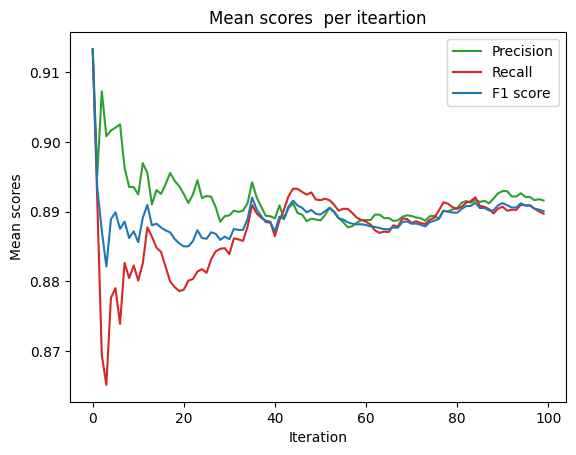

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

##comparison with GPT2 without fine-tuning

In [ ]:
#retrieve model and tokenizer
model_path = "gpt2-medium"
model = load_model(model_path)
tokenizer = load_tokenizer(model_path)
tokenizer.padding_side ='left'

scorer = BERTScorer(lang='en')

config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def generate_text_parall_raw(tokenizer, sequence, max_length):
    tokenizer.pad_token = tokenizer.eos_token

    ids = tokenizer(sequence, return_tensors='pt', padding=True ,truncation=True)

    final_outputs = model.generate(
        **ids,
        do_sample=True,
        max_length=max_length,
        pad_token_id=model.config.eos_token_id,
        top_k=50,
        top_p=0.95,
    )

    return [ tokenizer.decode(x, skip_special_tokens=True) for x in final_outputs ]

In [ ]:
P = np.array([])
R = np.array([])
F1 = np.array([])
merged_true_answers = [questions[i] + dataset["test"]["output"][i] for i in range(len(questions))]

n_sections = 6

for i in range(n_sections):
  print(i)
  first_index = int(sections[i])
  second_index= int(sections[i+1])
  responses = generate_text_parall_raw(tokenizer, questions[first_index : second_index], max_len)

  P_2, R_2, F1_2 = scorer.score(responses, merged_true_answers[first_index : second_index])
  P = np.append(P, P_2)
  R = np.append(R, R_2)
  F1 = np.append(F1, F1_2)
  print(f"BERTScore Precision : {np.mean(P):.4f}, Recall: {np.mean(R):.4f}, F1: {np.mean(F1):.4f}  #samples: {int((len(questions)/n_splits)*(i+1))}")

0
BERTScore Precision : 0.5996, Recall: 0.6922, F1: 0.6366  #samples: 16
1
BERTScore Precision : 0.6026, Recall: 0.6956, F1: 0.6385  #samples: 33
2
BERTScore Precision : 0.5966, Recall: 0.7251, F1: 0.6474  #samples: 50
3
BERTScore Precision : 0.5931, Recall: 0.7136, F1: 0.6400  #samples: 67
4
BERTScore Precision : 0.5935, Recall: 0.7184, F1: 0.6424  #samples: 84
5
BERTScore Precision : 0.5905, Recall: 0.7133, F1: 0.6389  #samples: 101


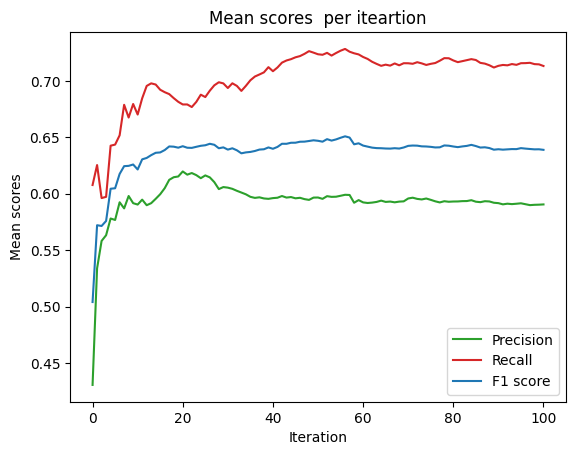

In [ ]:
def cum_mean(arr):
  cum_sum = np.cumsum(arr)
  return cum_sum/np.arange(1, len(arr) + 1)

plt.plot(cum_mean(P), color='#2ca02c',label='Precision')
plt.plot(cum_mean(R), color='#d62728',label='Recall')
plt.plot(cum_mean(F1),label='F1 score')

plt.ylabel('Mean scores')
plt.xlabel('Iteration')
plt.title("Mean scores  per iteartion")
plt.legend()
plt.show()

##Conclusions

As visible comparing the BertScore on Precision, Recall and F1 there is a visible improvement due to fine-tuning. Even handcraft valuation shows this result.
Answers provided by the model are quite good and accurate.